## Loading the saved model

In [105]:
from keras.src.saving import load_model

model = load_model('../Working_Files/model_1.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 30)     │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       960,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,081,492 (4.13 MB)

 Trainable params: 1,081,490 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [106]:
import cv2

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

### Predict Function to identify any image

In [107]:
import numpy as np

def predict_(img):
    img = cv2.resize(img,(32,32))
    
    img = Prep(img)
    img = np.array(img)
    
    img = img.reshape(1, 32, 32, 1)
    pred = model.predict(img)
    output = pred.argmax()
    
    return output, pred.argmax()

## Processing the given sudoku image and extracting relevant data

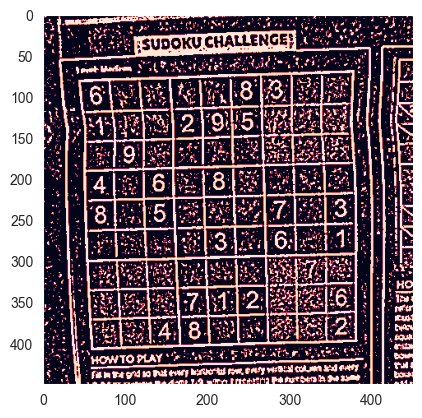

In [108]:
import matplotlib.pyplot as plt

sudoku_a = cv2.imread('../Working_Files/Sudoku_3.jpg')

#Preprocessing image to be read
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.grid(False)
plt.show()

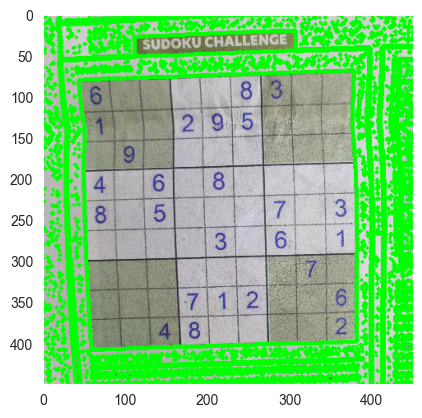

In [109]:
# Finding the outline of the sudoku puzzle in the image

contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.grid(False)
plt.show()

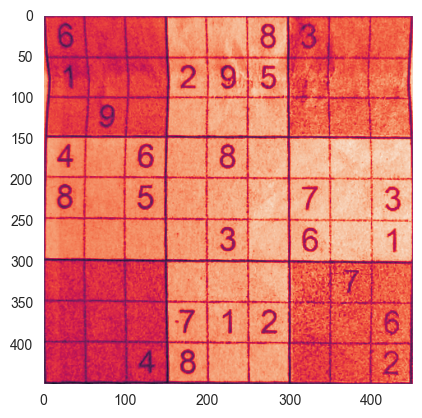

In [110]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.grid(False)
plt.show()


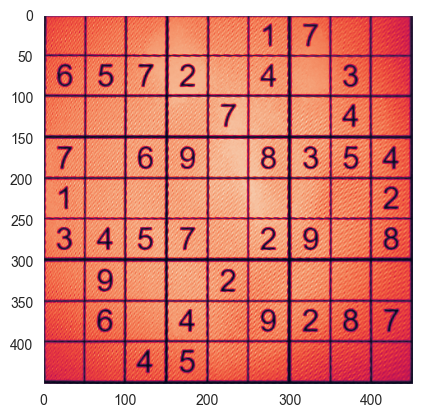

In [152]:
puzzle = cv2.imread('./Sudoku_5.jpg')

# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle 
su_puzzle = preprocess(puzzle)

# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= sudoku_a.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(su_imagewrap)
plt.grid(False)
plt.show()

81


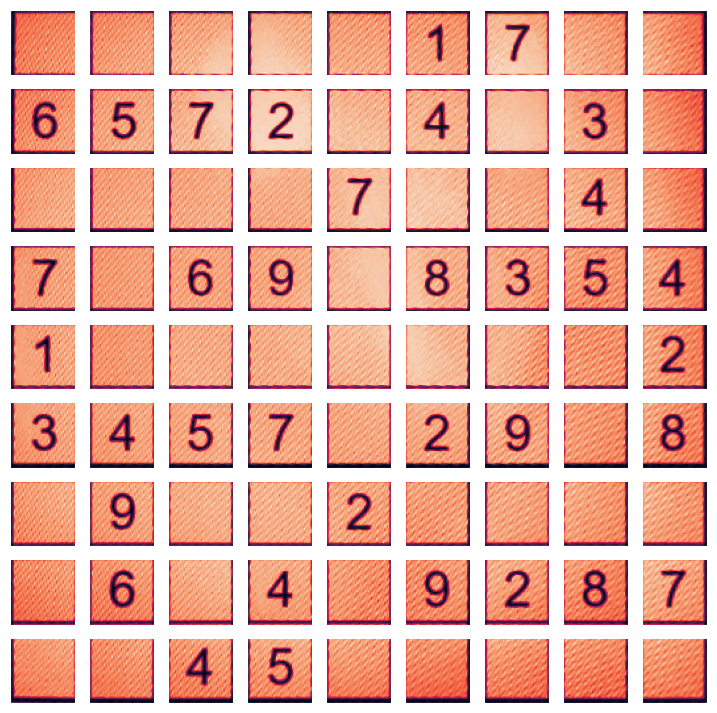

In [153]:
sudoku_cell = splitcells(su_imagewrap)

print(len(sudoku_cell))

plt.figure(figsize=(9, 9))
for i in range(len(sudoku_cell)):
    plt.subplot(9, 9, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sudoku_cell[i])
plt.show()

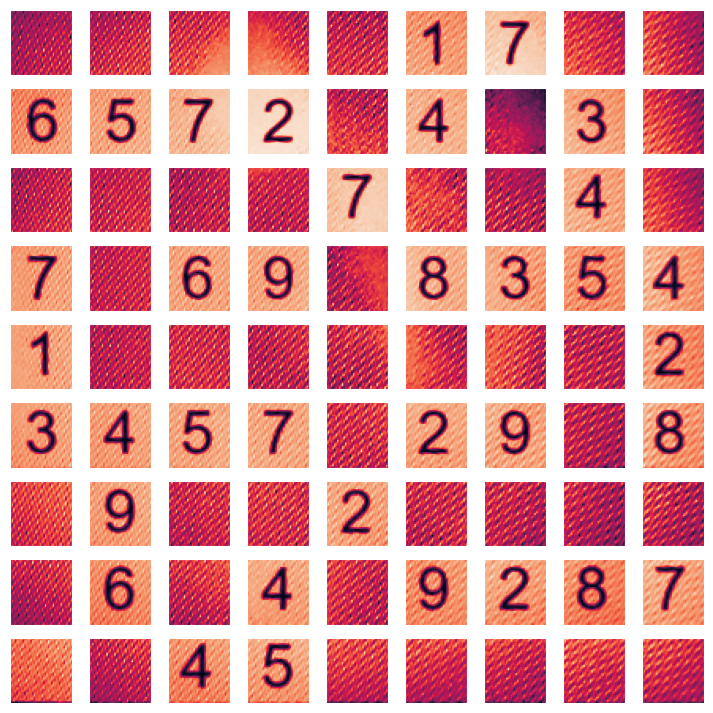

In [154]:
from PIL import Image


def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        # print(img.shape)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)

plt.figure(figsize=(9, 9))
for i in range(len(sudoku_cell)):
    plt.subplot(9, 9, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sudoku_cell_croped[i])
plt.show()

## ChatGPT

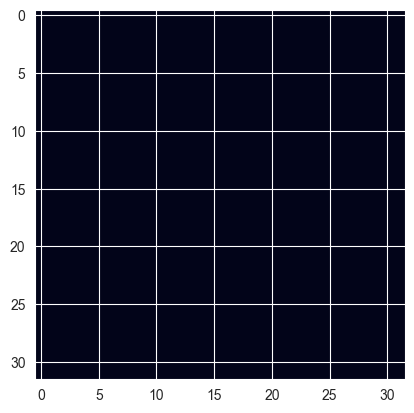

In [155]:
import cv2
import numpy as np

def is_blank(image, threshold=240, blank_ratio=0.95):
    # Check if the majority of the pixels are white or close to white
    num_white_pixels = np.sum(image > threshold)
    total_pixels = image.size
    white_ratio = num_white_pixels / total_pixels
    
    return white_ratio > blank_ratio

def clean_image(image):
    # Check if the image is blank
    if is_blank(image):
        # Return a completely white image to signify a blank cell
        return np.ones_like(image, dtype="uint8") * 255

    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply adaptive thresholding to get a binary image
    # binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 5)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same dimensions as the image, initialized to all zeros (black)
    mask = np.zeros_like(image)

    # Draw the contours on the mask
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    # Invert the mask to get the background as black and the digit area as white
    mask_inv = cv2.bitwise_not(mask)

    # Create a white background image
    white_background = np.ones_like(image, dtype="uint8") * 255

    # Copy the digit area from the original image to the white background
    digit = cv2.bitwise_and(image, image, mask=mask)
    cleaned_image = cv2.add(digit, white_background, mask=mask_inv)

    return cleaned_image

# Example usage
# Assuming 'sudoku_cell_croped' is a list of cropped cell images
image = sudoku_cell_croped[9]

# Ensure the image is 32x32
image = np.array(image)
image = cv2.resize(image, (32, 32))

cleaned_image = clean_image(image)

plt.imshow(cleaned_image)

In [158]:
def read_cells(cell,model):

    result = []
    for img in cell:
        # preprocess the image as it was in the model 
        img = np.asarray(img)
        # img = clean_image(img)
        # print(img.shape)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        # plt.imshow(img)
        plt.show()
        img = img.reshape(1, 32, 32, 1)
        
        # getting predictions and setting the values if probabilities are above 75% 
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=1)
        probabilityValue = np.amax(predictions)
        
        # print(classIndex)
        if probabilityValue > 0.75:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)
print(grid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━

In [159]:
for i in range(9):
    for j in range(9):
        print(grid[i*9 + j], end=' ')
    print("")

0 0 0 0 0 0 7 0 0 
6 5 7 2 0 4 0 3 0 
0 0 0 0 7 0 0 4 0 
7 0 6 9 0 8 3 5 4 
0 0 0 0 0 0 0 0 2 
3 4 5 7 0 2 9 0 8 
0 9 0 0 2 0 0 0 0 
0 6 0 4 0 9 2 8 7 
0 0 4 5 0 0 0 0 0 


In [160]:
grid = np.reshape(grid, (9,9))

def is_valid(board, row, col, num):
    # Check if 'num' is not in the current row
    if num in board[row, :]:
        return False
    # Check if 'num' is not in the current column
    if num in board[:, col]:
        return False
    # Check if 'num' is not in the current 3x3 subgrid
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    if num in board[start_row:start_row + 3, start_col:start_col + 3]:
        return False
    return True

def solve_sudoku(board):
    empty = np.where(board == 0)
    if len(empty[0]) == 0:  # No empty cells, puzzle solved
        return True
    
    row, col = empty[0][0], empty[1][0]

    for num in range(1, 10):
        if is_valid(board, row, col, num):
            board[row, col] = num
            if solve_sudoku(board):
                return True
            board[row, col] = 0  # Reset cell and backtrack

    return False

if solve_sudoku(grid):
    print("Sudoku solved successfully!")
    print(grid)
else:
    print("No solution exists.")


Sudoku solved successfully!
[[4 1 8 6 5 3 7 2 9]
 [6 5 7 2 9 4 8 3 1]
 [9 3 2 8 7 1 5 4 6]
 [7 2 6 9 1 8 3 5 4]
 [1 8 9 3 4 5 6 7 2]
 [3 4 5 7 6 2 9 1 8]
 [8 9 3 1 2 7 4 6 5]
 [5 6 1 4 3 9 2 8 7]
 [2 7 4 5 8 6 1 9 3]]


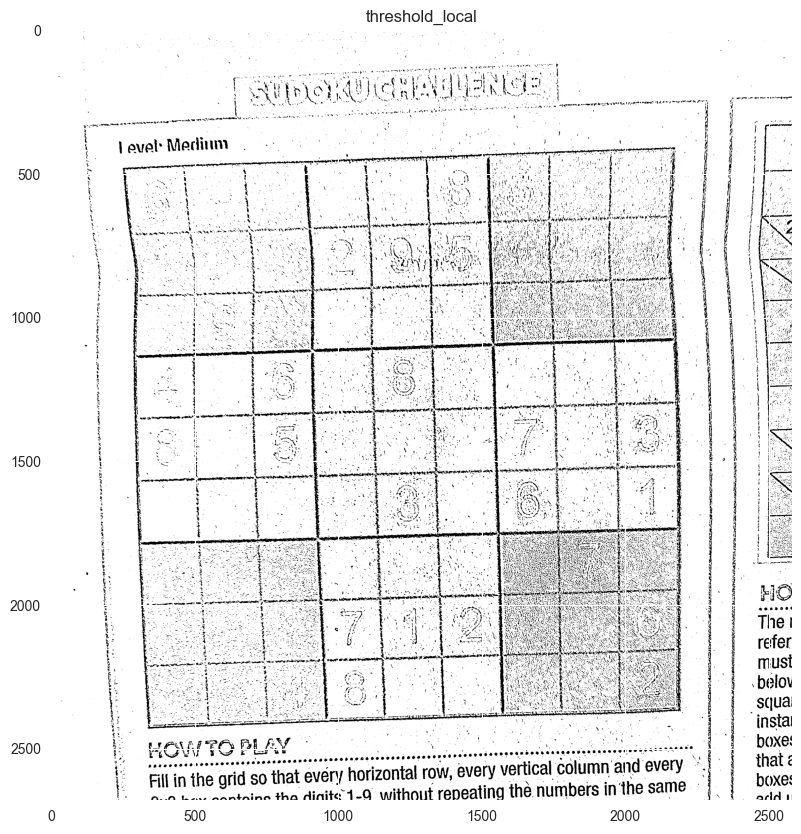

In [161]:
# Arora Code

def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

from skimage.filters import threshold_local

image = cv2.imread('./Sudoku_3.jpg')

# We get the Value component from the HSV color space
# then we apply adaptive thresholdingto

V = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))[2]
T = threshold_local(V, 25, offset=15, method="gaussian")

# Apply the threshold operation
thresh = (V > T).astype("uint8") * 255
imshow("threshold_local", thresh)